In [120]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import requests
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# set random seed for reproducible results
np.random.seed(17)

## Download and Prepare Data from NYC Department of Finance

In [3]:
# URLs
MANHATTAN = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_manhattan.xls'
BRONX = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_bronx.xls'
BROOKLYN = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_brooklyn.xls'
QUEENS = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_queens.xls'
STATEN_ISLAND = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_statenisland.xls'

datasets = [MANHATTAN, BRONX, BROOKLYN, QUEENS, STATEN_ISLAND]
boroughs = ['manhattan', 'bronx', 'brooklyn', 'queens', 'staten_island']

# make new directory for downloads if it doesn't alrady exist
nyc_directory = 'nyc_data'
if not os.path.exists(nyc_directory):
    os.makedirs(nyc_directory)

# write data from each file to nyc_directory folder
for idx in range(len(datasets)):
    resp = requests.get(datasets[idx])
    output = open(nyc_directory + '/' + boroughs[idx] + '_rolling_sales.xls', 'wb')
    output.write(resp.content)
    output.close()

In [4]:
# create file paths for all files in nyc_directory and concatenate files into one DF
files_locs = [nyc_directory + '/' + f for f in os.listdir(nyc_directory)]
df = pd.concat((pd.read_excel(f, skiprows=4) for f in files_locs))

orig_data_len = len(df)

df.head()


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,AIRPORT LA GUARDIA,01 ONE FAMILY DWELLINGS,1,976,29,NaN,A5,21-48 81ST STREET,NaN,...,1.0,0.0,1.0,1800.0,1224.0,1950.0,1,A5,730000,2018-07-19
1,4,AIRPORT LA GUARDIA,01 ONE FAMILY DWELLINGS,1,976,33,NaN,A5,21-56 81ST STREET,NaN,...,1.0,0.0,1.0,1800.0,1224.0,1950.0,1,A5,0,2018-10-12
2,4,AIRPORT LA GUARDIA,01 ONE FAMILY DWELLINGS,1,976,68,NaN,A5,21-07 80 STREET,NaN,...,1.0,0.0,1.0,1800.0,1224.0,1950.0,1,A5,822500,2018-11-21
3,4,AIRPORT LA GUARDIA,02 TWO FAMILY DWELLINGS,1,976,28,NaN,B3,2146 81ST STREET,NaN,...,2.0,0.0,2.0,1800.0,1224.0,1950.0,1,B3,735000,2019-02-19
4,4,AIRPORT LA GUARDIA,03 THREE FAMILY DWELLINGS,1,949,53,NaN,C0,19-75 80TH STREET,NaN,...,3.0,0.0,3.0,2000.0,2835.0,1945.0,1,C0,0,2018-09-21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81747 entries, 0 to 16745
Data columns (total 21 columns):
BOROUGH                           81747 non-null int64
NEIGHBORHOOD                      81747 non-null object
BUILDING CLASS CATEGORY           81747 non-null object
TAX CLASS AT PRESENT              81689 non-null object
BLOCK                             81747 non-null int64
LOT                               81747 non-null int64
EASE-MENT                         0 non-null float64
BUILDING CLASS AT PRESENT         81689 non-null object
ADDRESS                           81747 non-null object
APARTMENT NUMBER                  17876 non-null object
ZIP CODE                          81733 non-null float64
RESIDENTIAL UNITS                 81689 non-null float64
COMMERCIAL UNITS                  81689 non-null float64
TOTAL UNITS                       81689 non-null float64
LAND SQUARE FEET                  81686 non-null float64
GROSS SQUARE FEET                 81689 non-null flo

In [6]:
# clean up column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# convert categorical columns to category datatype
categorical_vars = ['borough', 'neighborhood', 'building_class_category', 'tax_class_at_present', 
                    'building_class_at_present', 'tax_class_at_time_of_sale', 'building_class_at_time_of_sale']
for col in categorical_vars:
    df[col] = df[col].astype('category')

# convert tax_class_at_present to string type    
df['tax_class_at_present'] = df['tax_class_at_present'].astype(str)

cols_to_drop = ['ease_ment',
                'address',
                'apartment_number',
                'building_class_at_time_of_sale', # building class encapsulated with building class category
                'building_class_at_present']

# drop empty/irrelevant columns
df.drop(cols_to_drop, axis=1, inplace=True)

# convert sale date to date_time
df.sale_date = pd.to_datetime(df.sale_date, '%y-%m-%d')

In [7]:
# number and percentage of rows with NaN values
print('Number of rows with NaN: {}'.format(df.isna().any(axis=1).sum()))
print('Percentage of rows with any NaN: {:.2%}'.format((df.isna().any(axis=1).sum() / len(df))))


Number of rows with NaN: 64
Percentage of rows with any NaN: 0.08%


In [8]:
# drop rows with any NaN values
df = df.dropna(axis=0, how='any')

# delete duplicates
df = df.drop_duplicates()


In [9]:
print('Original number of rows: {}'.format(orig_data_len))
print('Number of rows removed from basic cleaning: {}'.format(orig_data_len - len(df)))
print('Rows remaining after cleaning: {}'.format(len(df)))


Original number of rows: 81747
Number of rows removed from basic cleaning: 792
Rows remaining after cleaning: 80955


In [10]:
# force 0 entries in certain columns to na (ie a property can't have size 0 square feet)
zeros_to_fill_cols = ['land_square_feet', 'gross_square_feet', 'year_built']
df[zeros_to_fill_cols] = df[zeros_to_fill_cols].replace(0,np.nan)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80955 entries, 0 to 16745
Data columns (total 16 columns):
borough                      80955 non-null category
neighborhood                 80955 non-null category
building_class_category      80955 non-null category
tax_class_at_present         80955 non-null object
block                        80955 non-null int64
lot                          80955 non-null int64
zip_code                     80955 non-null float64
residential_units            80955 non-null float64
commercial_units             80955 non-null float64
total_units                  80955 non-null float64
land_square_feet             54087 non-null float64
gross_square_feet            61553 non-null float64
year_built                   74800 non-null float64
tax_class_at_time_of_sale    80955 non-null category
sale_price                   80955 non-null int64
sale_date                    80955 non-null datetime64[ns]
dtypes: category(4), datetime64[ns](1), float64(7), int

In [12]:
df.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_price
count,80955.000000,80955.000000,80955.000000,80955.000000,80955.000000,80955.000000,5.408700e+04,6.155300e+04,74800.000000,8.095500e+04
mean,4401.227633,357.876005,10798.946452,1.896090,0.229943,2.209549,8.459751e+03,3.728809e+03,1949.829238,1.202057e+06
std,3638.443250,657.109645,989.397737,15.146628,5.225884,16.222622,3.123088e+04,2.472971e+04,34.119190,1.361512e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,1798.000000,0.000000e+00
25%,1362.000000,21.000000,10306.000000,0.000000,0.000000,1.000000,2.000000e+03,1.152000e+03,1925.000000,0.000000e+00
50%,3487.000000,49.000000,11210.000000,1.000000,0.000000,1.000000,2.608000e+03,1.680000e+03,1945.000000,4.470000e+05
75%,6571.000000,304.000000,11358.000000,2.000000,0.000000,2.000000,4.275000e+03,2.520000e+03,1970.000000,8.500000e+05
max,16350.000000,9101.000000,11697.000000,2229.000000,1132.000000,2229.000000,1.150244e+06,1.741458e+06,2019.000000,2.397502e+09


## Visualizations

<Figure size 432x288 with 0 Axes>

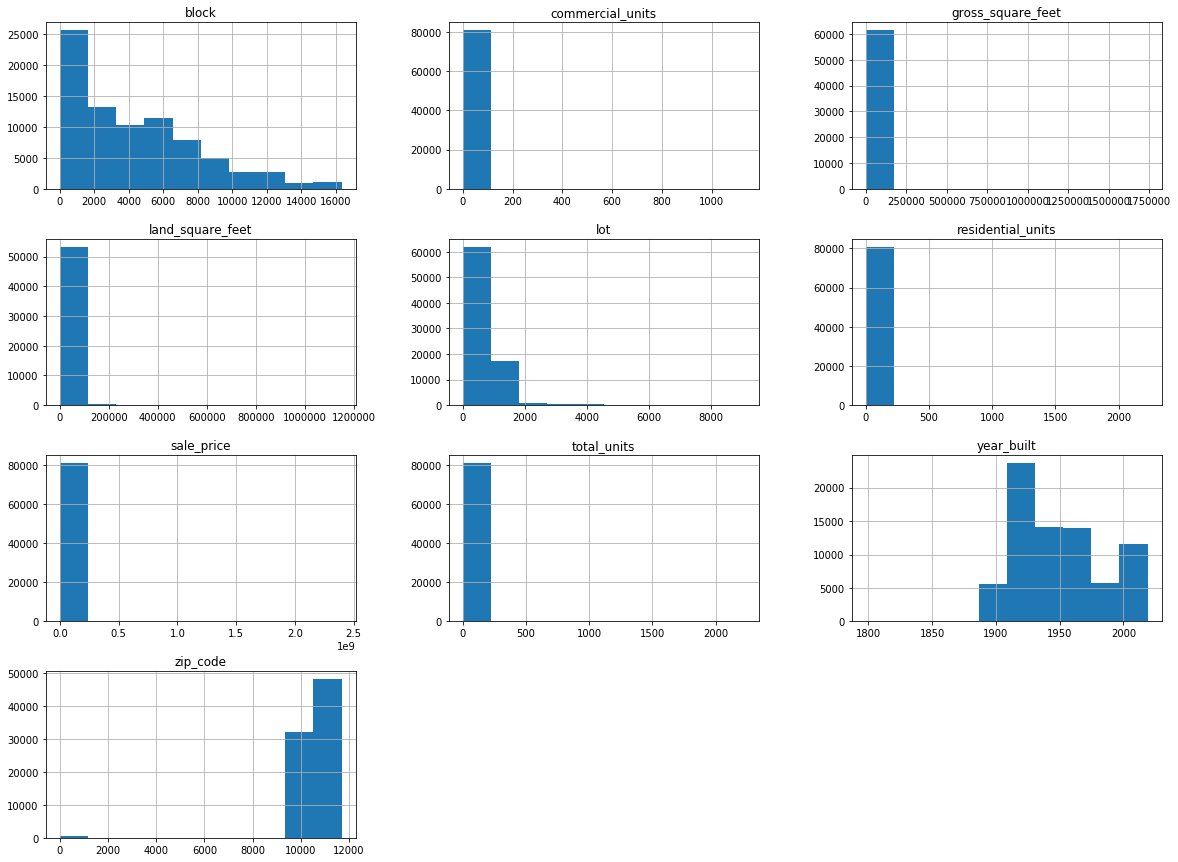

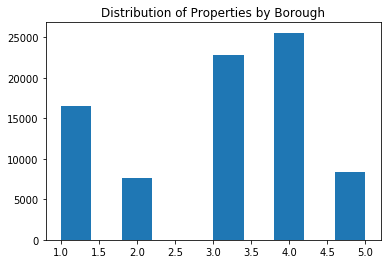

In [13]:
plt.figure()
df.hist(figsize=(20,15))
plt.show()

plt.figure()
plt.hist(df['borough'])
plt.title('Distribution of Properties by Borough')
plt.show()

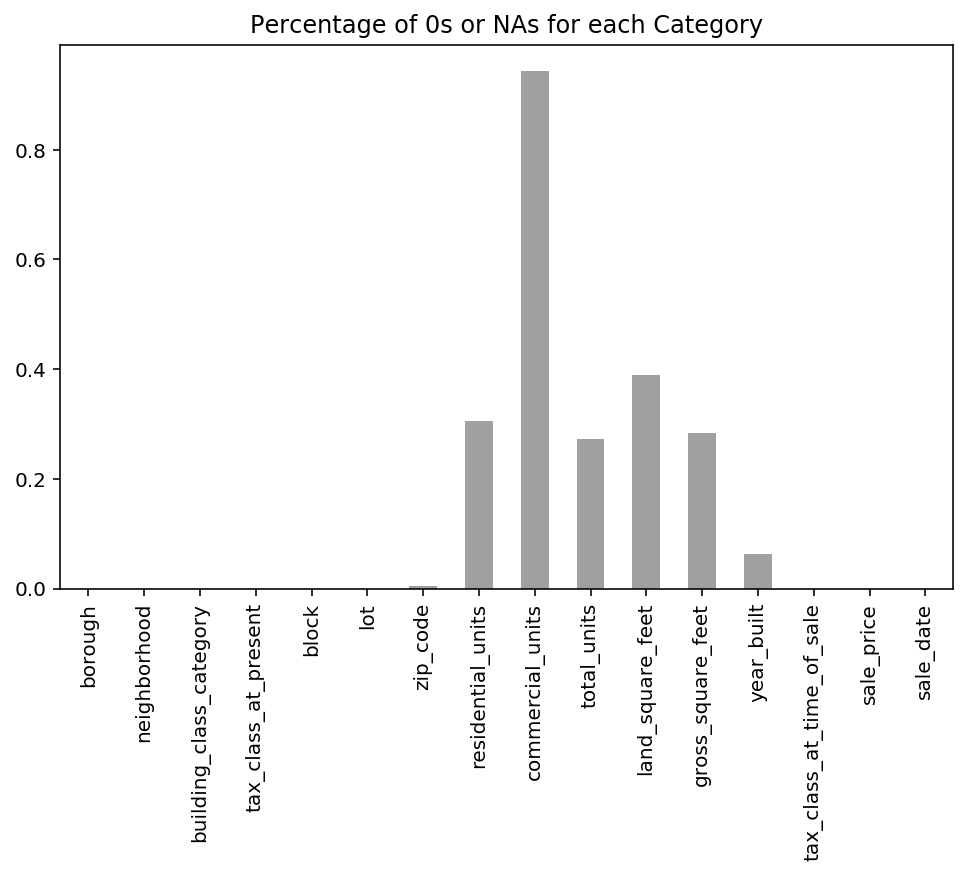

In [370]:
num_zeros = ((df == 0).sum() + df.isna().sum()) / len(df)

num_zeros.plot.bar(figsize=(8,5), color='grey', alpha=.75)
plt.title('Percentage of 0s or NAs for each Category')

plt.show()

/Users/alexsadler/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


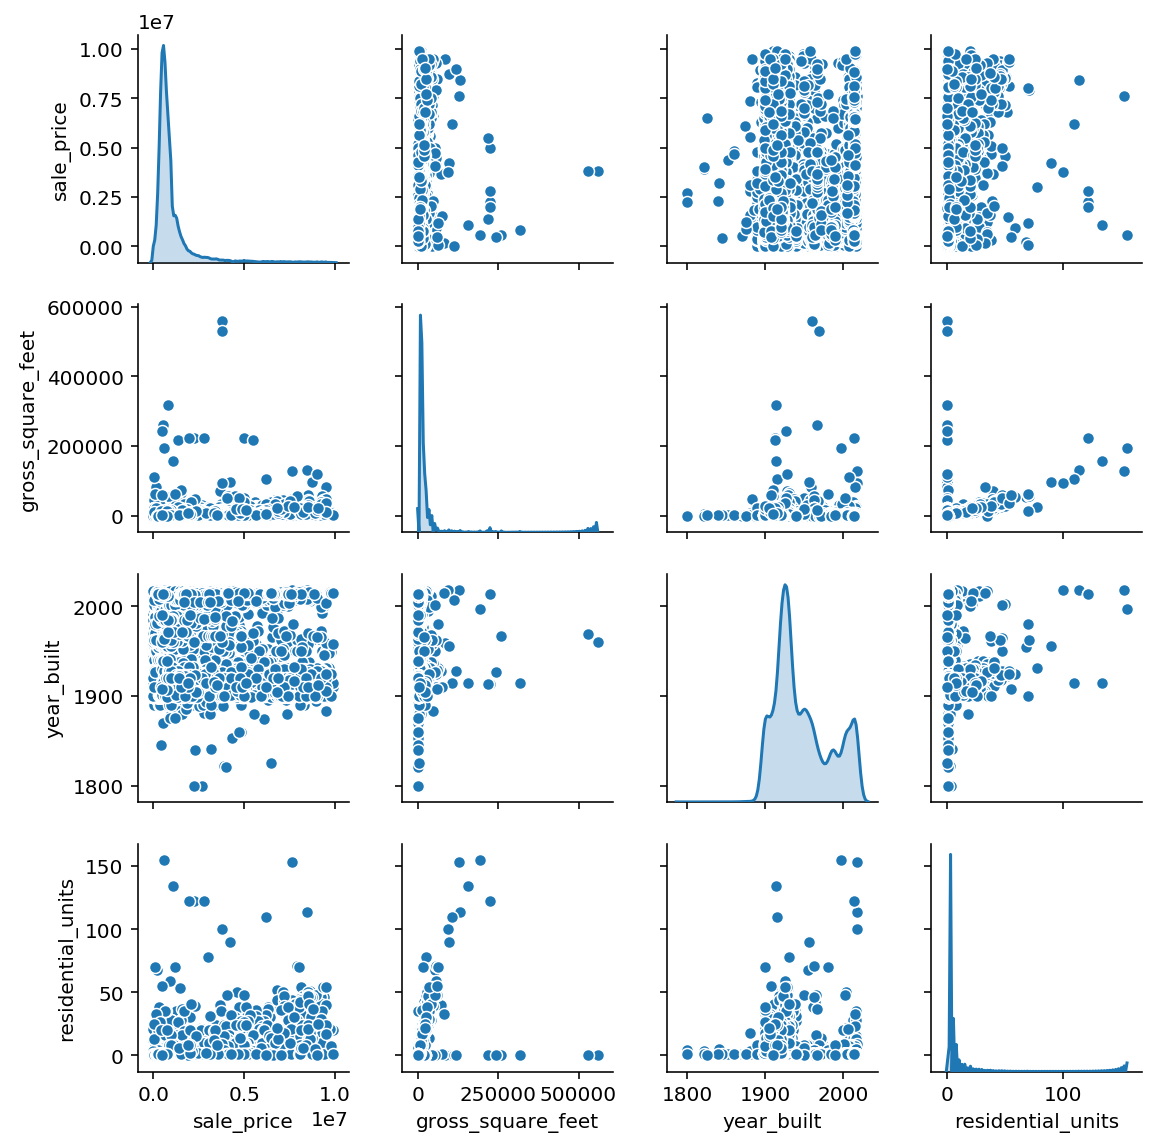

In [368]:
attribs = ['sale_price', 'gross_square_feet', 'year_built', 'residential_units']
sns.pairplot(df.dropna()[attribs], diag_kind='kde', height=2)


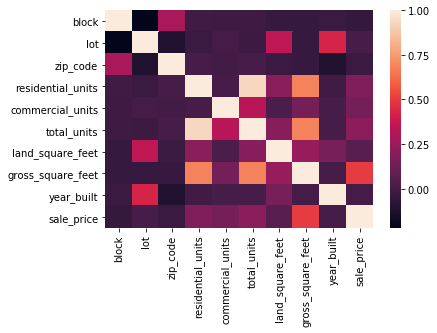

In [16]:
#correlation between the features
sns.heatmap(df.corr())

In [17]:
df.corr()['sale_price'].sort_values(ascending=False)

sale_price           1.000000
gross_square_feet    0.504759
total_units          0.210346
residential_units    0.174248
commercial_units     0.146396
land_square_feet     0.066898
lot                  0.007043
year_built           0.001171
zip_code            -0.030290
block               -0.047736
Name: sale_price, dtype: float64

In [18]:
# show differences in prices by borough (motivation for stratified sampling)
df.groupby('borough')['sale_price'].mean()

borough
1    3.240068e+06
2    6.320503e+05
3    8.909378e+05
4    5.849299e+05
5    4.204629e+05
Name: sale_price, dtype: float64

## Prepare Data For Machine Learning Implementation

#### Filter Target Values

In [107]:
# filter data to include only relevant prices 
df_rm = df[(df['sale_price'] > 1000)    &      # exclude transfers of property
           (df['sale_price'] < 10000000)]      # remove extreme prices
    

In [108]:
print('Original number of rows: {}'.format(len(df)))
print('Number of rows removed: {}'.format(len(df) - len(df_rm)))
print('Rows remaining after excluding tansfers of property and extreme prices: {}'.format(len(df_rm)))

Original number of rows: 54730
Number of rows removed: 0
Rows remaining after excluding tansfers of property and extreme prices: 54730


#### One-Hot Encoding
http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example

In [109]:
df = df_rm

# save original borough list for stratified sampling below
borough_list = df['borough']

# categorical columns
df_cat = df.select_dtypes(exclude=[np.number, np.datetime64])
cat_attribs = list(df_cat.columns)

# get one-hot encoded matrix of categorical variables
dummies_matrix = pd.get_dummies(df[cat_attribs])

# concatenate original df and one-hot encoded df and drop original cat columns
df_onehot = pd.concat([df, dummies_matrix], axis=1)
df_onehot = df_onehot.drop(cat_attribs, axis=1)

X = df_onehot.drop('sale_price', axis=1)
y = df_onehot.sale_price

df_onehot.head()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_price,...,tax_class_at_present_1C,tax_class_at_present_1D,tax_class_at_present_2,tax_class_at_present_2A,tax_class_at_present_2B,tax_class_at_present_2C,tax_class_at_present_4,tax_class_at_time_of_sale_1,tax_class_at_time_of_sale_2,tax_class_at_time_of_sale_4
0,976,29,11370.0,1.0,0.0,1.0,1800.0,1224.0,1950.0,730000,...,0,0,0,0,0,0,0,1,0,0
2,976,68,11370.0,1.0,0.0,1.0,1800.0,1224.0,1950.0,822500,...,0,0,0,0,0,0,0,1,0,0
3,976,28,11370.0,2.0,0.0,2.0,1800.0,1224.0,1950.0,735000,...,0,0,0,0,0,0,0,1,0,0
5,949,1028,11370.0,1.0,0.0,1.0,NaN,836.0,NaN,480000,...,0,0,1,0,0,0,0,0,1,0
6,15828,4,11691.0,1.0,0.0,1.0,1552.0,1000.0,1940.0,360000,...,0,0,0,0,0,0,0,1,0,0


#### Use Stratified Sampling Based on Boroughs to Obtain Train and Test Set

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=borough_list, test_size=0.2, random_state=17)


#### Impute NA Values for Square Feet and Year Built Columns with Median

In [112]:
print("Columns with NA Values: {}".format(list(X_train.columns[X_train.isna().any()])))
num_attribs = list(X_train.select_dtypes(include=[np.number]))

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('std_scaler', StandardScaler())])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs)])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

Columns with NA Values: ['land_square_feet', 'gross_square_feet', 'year_built']


## Modeling

### Linear Regression Models

#### Linear Regression

In [29]:
# fit linear regression to train set
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [329]:
lin_reg_train_pred = lin_reg.predict(X_train_prepared)
lin_reg_test_pred = lin_reg.predict(X_test_prepared)

print('Linear regression train sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(lin_reg_train_pred, y_train))))
print('Linear regression test sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(lin_reg_test_pred, y_test))))
print()
print('Linear regression train sample R-squared: {:.2f}'.format(lin_reg.score(X_train_prepared, y_train)))
print('Linear regression test sample R-squared: {:.2f}'.format(lin_reg.score(X_test_prepared, y_test)))
print()

print('Linear regression number of non-zero coefs: {}'.format(sum(lin_reg.coef_ != 0)))

Linear regression train sample MSE: 880410
Linear regression test sample MSE: 833052

Linear regression train sample R-squared: 0.45
Linear regression test sample R-squared: 0.48

Linear regression number of non-zero coefs: 324


In [298]:
weights = zip(abs(lin_reg.coef_), X_train.drop('sale_date', axis=1).columns)
sorted(weights, reverse=True)[:10]

[(6.014214886489935e+18, 'tax_class_at_time_of_sale_1'),
 (3.9372324944455526e+18, 'tax_class_at_present_1'),
 (3.908580722467714e+18, 'tax_class_at_present_2'),
 (3.2459398194742615e+18, 'tax_class_at_time_of_sale_2'),
 (2.1422017228873882e+18, 'neighborhood_FRESH KILLS'),
 (1.8742922212153772e+18,
  'building_class_category_10 COOPS - ELEVATOR APARTMENTS'),
 (1.688581448795695e+18,
  'building_class_category_13 CONDOS - ELEVATOR APARTMENTS'),
 (1.5650547512786831e+18, 'tax_class_at_present_4'),
 (1.5057599268761093e+18, 'borough_3'),
 (1.3936376443856177e+18, 'borough_1')]

#### Lasso Regression

In [285]:
param_grid = [{'alpha': [1, 3, 10, 30, 100]}]

lasso_reg_cv = Lasso(max_iter=1000, tol=.01)
grid_search_lasso = GridSearchCV(lasso_reg_cv, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_prepared, y_train)

print(grid_search_lasso.best_params_)
lasso_final = grid_search_lasso.best_estimator_

/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: 

/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: 

/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 30}


/Users/alexsadler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [327]:
lasso_reg_train_pred = lasso_final.predict(X_train_prepared)
lasso_reg_test_pred = lasso_final.predict(X_test_prepared)

print('Lasso regression train sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(lasso_reg_train_pred, y_train))))
print('Lasso regression test sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(lasso_reg_test_pred, y_test))))
print()
print('Lasso regression train sample R-squared: {:.2f}'.format(lasso_final.score(X_train_prepared, y_train)))
print('Lasso regression test sample R-squared: {:.2f}'.format(lasso_final.score(X_test_prepared, y_test)))

print()
print('Lasso regression number of non-zero coefs: {}'.format(sum(lasso_final.coef_ != 0)))


Lasso regression train sample MSE: 880425
Lasso regression test sample MSE: 832774

Lasso regression train sample R-squared: 0.45
Lasso regression test sample R-squared: 0.48

Lasso regression number of non-zero coefs: 319


In [297]:
weights = zip(abs(lasso_final.coef_), X_train.drop('sale_date', axis=1).columns)
sorted(weights, reverse=True)[:10]

[(636851.0136635603, 'tax_class_at_time_of_sale_1'),
 (588767.7949714073, 'building_class_category_07 RENTALS - WALKUP APARTMENTS'),
 (540499.8146535524, 'tax_class_at_present_1'),
 (515251.9232585978, 'borough_1'),
 (361065.2755269595, 'tax_class_at_present_2A'),
 (297024.1551179665, 'building_class_category_14 RENTALS - 4-10 UNIT'),
 (290548.71021912555,
  'building_class_category_10 COOPS - ELEVATOR APARTMENTS'),
 (212668.10512713014, 'tax_class_at_present_2'),
 (174504.6710661754, 'tax_class_at_time_of_sale_4'),
 (169206.00460476204, 'building_class_category_09 COOPS - WALKUP APARTMENTS')]

#### Ridge Regression

In [287]:
param_grid = [{'alpha': [1, 3, 10, 30, 100]}]

ridge_reg_cv = Ridge()
grid_search_ridge = GridSearchCV(ridge_reg_cv, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_prepared, y_train)

print(grid_search_ridge.best_params_)
ridge_final = grid_search_ridge.best_estimator_

{'alpha': 10}


In [330]:
ridge_reg_train_pred = ridge_final.predict(X_train_prepared)
ridge_reg_test_pred = ridge_final.predict(X_test_prepared)

print('Ridge regression train sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(ridge_reg_train_pred, y_train))))
print('Ridge regression test sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(ridge_reg_test_pred, y_test))))
print()
print('Ridge regression train sample R-squared: {:.2f}'.format(ridge_final.score(X_train_prepared, y_train)))
print('Ridge regression test sample R-squared: {:.2f}'.format(ridge_final.score(X_test_prepared, y_test)))
print()
print('Ridge regression number of non-zero coefs: {}'.format(sum(ridge_final.coef_ != 0)))


Ridge regression train sample MSE: 880320
Ridge regression test sample MSE: 832624

Ridge regression train sample R-squared: 0.45
Ridge regression test sample R-squared: 0.48

Ridge regression number of non-zero coefs: 321


In [296]:
weights = zip(abs(ridge_final.coef_), X_train.drop('sale_date', axis=1).columns)
sorted(weights, reverse=True)[:10]

[(540262.1832936981, 'building_class_category_07 RENTALS - WALKUP APARTMENTS'),
 (539961.1505453158, 'tax_class_at_present_2'),
 (479300.01936252374, 'tax_class_at_present_1'),
 (420173.05217688915,
  'building_class_category_10 COOPS - ELEVATOR APARTMENTS'),
 (387389.88755906734, 'tax_class_at_time_of_sale_2'),
 (337347.5657276837, 'tax_class_at_time_of_sale_1'),
 (274353.0278180887, 'building_class_category_14 RENTALS - 4-10 UNIT'),
 (268829.26240188157, 'tax_class_at_present_2A'),
 (241215.99229317956, 'borough_1'),
 (234789.54914322443, 'building_class_category_09 COOPS - WALKUP APARTMENTS')]

### Nonlinear Regression Models

#### Decision Trees

In [305]:
param_grid = [{'max_depth': [1, 5, 10, 15, 20, 25],
               'min_samples_split': [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
               'min_samples_leaf': [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]}]

tree_reg_cv = DecisionTreeRegressor()
grid_search_dectree = GridSearchCV(tree_reg_cv, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_dectree.fit(X_train_prepared, y_train)

print(grid_search_dectree.best_params_)
tree_reg_final = grid_search_dectree.best_estimator_

{'max_depth': 15, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}


In [332]:
tree_reg_train_pred = tree_reg_final.predict(X_train_prepared)
tree_reg_test_pred = tree_reg_final.predict(X_test_prepared)

print('Decision tree train sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(tree_reg_train_pred, y_train))))
print('Decision tree test sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(tree_reg_test_pred, y_test))))
print()
print('Decision tree train sample R-squared: {:.2f}'.format(tree_reg_final.score(X_train_prepared, y_train)))
print('Decision tree test sample R-squared: {:.2f}'.format(tree_reg_final.score(X_test_prepared, y_test)))

Decision tree test sample MSE: 797636
Decision tree test sample MSE: 768131

Decision tree train sample R-squared: 0.55
Decision tree test sample R-squared: 0.55


In [333]:
weights = zip(tree_reg_final.feature_importances_, X_train.drop('sale_date', axis=1).columns)
sorted(weights, reverse=True)[:10]

[(0.634830602273304, 'gross_square_feet'),
 (0.17239148986292474, 'borough_1'),
 (0.06630057177565309, 'zip_code'),
 (0.056397842139249844, 'block'),
 (0.024054271532025953, 'borough_3'),
 (0.011273667905201935, 'total_units'),
 (0.009531086947408804, 'year_built'),
 (0.005752347715732838,
  'building_class_category_09 COOPS - WALKUP APARTMENTS'),
 (0.004569942283811997, 'tax_class_at_present_2'),
 (0.0036617838708363753, 'tax_class_at_time_of_sale_1')]

#### Random Forest

In [335]:
param_grid = [{'n_estimators': [1, 50, 100, 150, 200]}]

rand_forest_reg = RandomForestRegressor()
grid_search_rand_forest = GridSearchCV(rand_forest_reg, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_rand_forest.fit(X_train_prepared, y_train)

print(grid_search_rand_forest.best_params_)
rand_forest_final = grid_search_rand_forest.best_estimator_

{'n_estimators': 150}


In [339]:
rand_forest_final = RandomForestRegressor(n_estimators=150, max_depth=15)
rand_forest_final.fit(X_train_prepared, y_train)

rand_forest_train_pred = rand_forest_final.predict(X_train_prepared)
rand_forest_test_pred = rand_forest_final.predict(X_test_prepared)

print('Random forest train sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(rand_forest_train_pred, y_train))))
print('Random forest test sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(rand_forest_test_pred, y_test))))
print()
print('Random forest train sample R-squared: {:.2f}'.format(rand_forest_final.score(X_train_prepared, y_train)))
print('Random forest test sample R-squared: {:.2f}'.format(rand_forest_final.score(X_test_prepared, y_test)))

Random forest train sample MSE: 418550
Random forest test sample MSE: 615539

Random forest train sample R-squared: 0.88
Random forest test sample R-squared: 0.71


In [321]:
weights = zip(rand_forest_final.feature_importances_, X_train.drop('sale_date', axis=1).columns)
sorted(weights, reverse=True)[:10]

[(0.41474175859140755, 'gross_square_feet'),
 (0.12679925888390847, 'borough_1'),
 (0.11621450135652976, 'block'),
 (0.056848416245951675, 'lot'),
 (0.048207290132330646, 'year_built'),
 (0.03961728382656165, 'land_square_feet'),
 (0.03902252587434674, 'zip_code'),
 (0.015698171585130743, 'total_units'),
 (0.014953516689250747, 'borough_3'),
 (0.011818345289693936, 'residential_units')]

#### Neural Networks

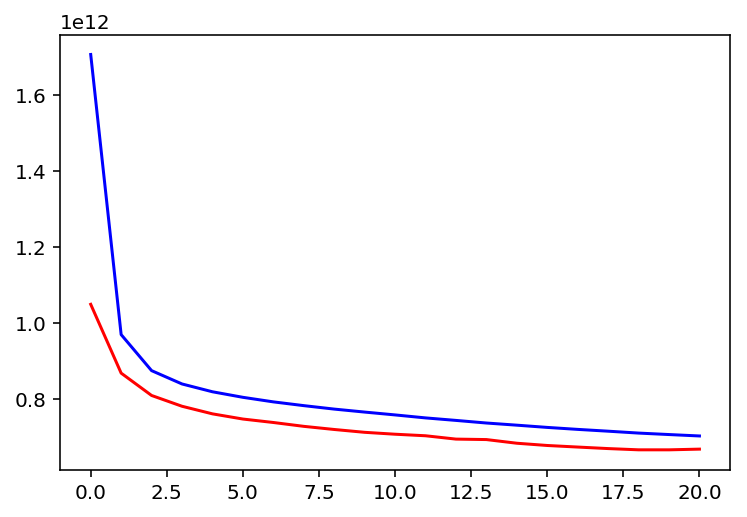

In [373]:
#Defines linear regression model and its structure
model = Sequential()
model.add(Dense(324, input_shape=(324,), activation='relu'))
model.add(Dense(324, input_shape=(324,), activation='relu'))
model.add(Dense(1))

#Compiles model
model.compile(Adam(lr=0.001), 'mean_squared_error')
callbacks = [EarlyStopping(monitor='val_loss', patience=1), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#Fits model
history = model.fit(X_train_prepared, y_train, callbacks=callbacks, epochs = 200, validation_split = 0.1, verbose = 0)
history_dict=history.history

#Plots model's training cost/loss and model's validation split cost/loss
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')

In [374]:
nn_train_pred = model.predict(X_train_prepared)
nn_test_pred = model.predict(X_test_prepared)

print('Neural network train sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(nn_train_pred, y_train))))
print('Neural network test sample MSE: {:.0f}'.format(np.sqrt(mean_squared_error(nn_test_pred, y_test))))
print()
print('Neural network train sample R-squared: {:.2f}'.format(r2_score(nn_train_pred, y_train)))
print('Neural network test sample R-squared: {:.2f}'.format(r2_score(nn_test_pred, y_test)))

Neural network train sample MSE: 832780
Neural network test sample MSE: 799460

Neural network train sample R-squared: -0.05
Neural network test sample R-squared: 0.05
